In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
        
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate)*(grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate)*(grads["db" + str(l+1)])        
    return parameters

In [3]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))

W1 =
[[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 =
[[ 1.74604067]
 [-0.75184921]]
W2 =
[[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 =
[[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


In [4]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
        
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*(mini_batch_size):(k+1)*(mini_batch_size)]
        mini_batch_Y = shuffled_Y[:,k*(mini_batch_size):(k+1)*(mini_batch_size)]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,k*(mini_batch_size):m]
        mini_batch_Y = shuffled_Y[:,k*(mini_batch_size):m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [5]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 84)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 84)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


In [10]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2
    v = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W"+str(l+1)].shape[0],parameters["W"+str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b"+str(l+1)].shape[0],parameters["b"+str(l+1)].shape[1]))
        
    return v

In [11]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))

v["dW1"] =
[[ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db1"] =
[[ 0.]
 [ 0.]]
v["dW2"] =
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db2"] =
[[ 0.]
 [ 0.]
 [ 0.]]


In [12]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2
    
    for l in range(L):
        v["dW" + str(l+1)] = beta*(v["dW" + str(l+1)])+(1-beta)*(grads['dW' + str(l+1)])
        v["db" + str(l+1)] = beta*(v["db" + str(l+1)])+(1-beta)*(grads['db' + str(l+1)])
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*(v["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*(v["db" + str(l+1)])
        
    return parameters, v

In [13]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))

W1 = 
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
[[ 1.74493465]
 [-0.76027113]]
W2 = 
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = v[[ 0.02344157]
 [ 0.16598022]
 [ 0.07420442]]


In [14]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0],parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0],parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0],parameters["b" + str(l+1)].shape[1]))
    
    return v, s

In [15]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

v["dW1"] = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db1"] = 
[[ 0.]
 [ 0.]]
v["dW2"] = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db2"] = 
[[ 0.]
 [ 0.]
 [ 0.]]
s["dW1"] = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]]
s["db1"] = 
[[ 0.]
 [ 0.]]
s["dW2"] = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
s["db2"] = 
[[ 0.]
 [ 0.]
 [ 0.]]


In [21]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = beta1*(v["dW" + str(l+1)])+(1-beta1)*(grads['dW' + str(l+1)])
        v["db" + str(l+1)] = beta1*(v["db" + str(l+1)])+(1-beta1)*(grads['db' + str(l+1)])
        v_corrected["dW" + str(l+1)] = (v["dW" + str(l+1)])/(1-pow(beta1,l+1))
        v_corrected["db" + str(l+1)] = (v["db" + str(l+1)])/(1-pow(beta1,l+1))
        s["dW" + str(l+1)] = beta2*(s["dW" + str(l+1)])+ (1-beta2)*(pow(grads['dW' + str(l+1)],2))
        s["db" + str(l+1)] = beta2*(s["db" + str(l+1)])+ (1-beta2)*(pow(grads['db' + str(l+1)],2))
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-pow(beta2,l+1))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-pow(beta2,l+1))
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]- learning_rate*(v_corrected["dW" + str(l+1)])/pow((s_corrected["dW" + str(l+1)]+epsilon),0.5)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]- learning_rate*(v_corrected["db" + str(l+1)])/pow((s_corrected["db" + str(l+1)]+epsilon),0.5)

    return parameters, v, s

In [22]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

W1 = 
[[ 1.63434536 -0.62175641 -0.53817175]
 [-1.08296862  0.85540763 -2.2915387 ]]
b1 = 
[[ 1.75481176]
 [-0.7512069 ]]
W2 = 
[[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = 
[[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = 
[[ 0.02344157]
 [ 0.16598022]
 [ 0.07420442]]
s["dW1"] = 
[[ 0.00121136  0.00131039  0.00081287]
 [ 0.0002525   0.00081154  0.00046748]]
s["db1"] = 
[[  1.51020075e-05]
 [  8.75664434e-04]]
s["dW2"] = 
[[  7.17640232e-05   2.81276921e-04   4.78394595e-04]
 [  1.57413361e-04   4.72206320e-04   7.14372576e-04]
 [  4.50571368e-04   1.60392066e-07   1.24838242e-03]]
s["db2"] = 
[[  5.49507194e-05]
 [  2.75494327e-03]
 [  5.506

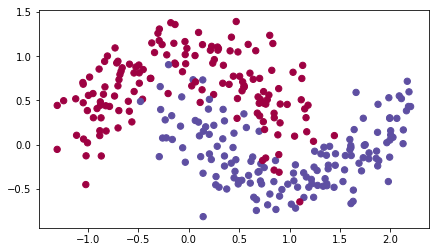

In [23]:
train_X, train_Y = load_dataset()

In [24]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]
    
    parameters = initialize_parameters(layers_dims)
    if optimizer == "gd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            a3, caches = forward_propagation(minibatch_X, parameters)
            cost_total += compute_cost(a3, minibatch_Y)
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.849612
Cost after epoch 1000: 0.810357
Cost after epoch 2000: 0.770425
Cost after epoch 3000: 0.726664
Cost after epoch 4000: 0.697570
Cost after epoch 5000: 0.668377
Cost after epoch 6000: 0.639754
Cost after epoch 7000: 0.635574
Cost after epoch 8000: 0.602443
Cost after epoch 9000: 0.573087


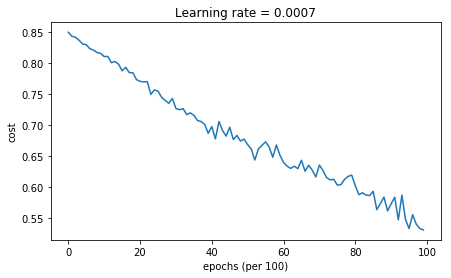

Accuracy: 0.796666666667


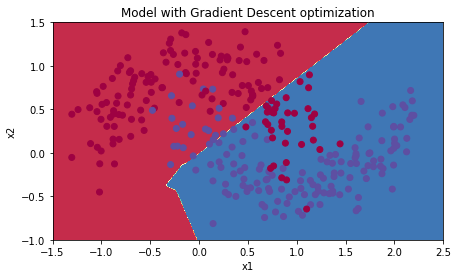

In [25]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.849621
Cost after epoch 1000: 0.810435
Cost after epoch 2000: 0.770547
Cost after epoch 3000: 0.726786
Cost after epoch 4000: 0.697672
Cost after epoch 5000: 0.668466
Cost after epoch 6000: 0.639864
Cost after epoch 7000: 0.635697
Cost after epoch 8000: 0.602890
Cost after epoch 9000: 0.573321


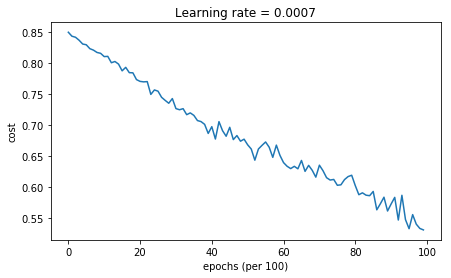

Accuracy: 0.796666666667


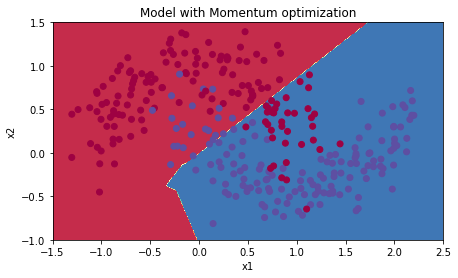

In [26]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")
predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.849308
Cost after epoch 1000: 0.433935
Cost after epoch 2000: 0.295982
Cost after epoch 3000: 0.233159
Cost after epoch 4000: 0.211810
Cost after epoch 5000: 0.187825
Cost after epoch 6000: 0.172159
Cost after epoch 7000: 0.177299
Cost after epoch 8000: 0.169661
Cost after epoch 9000: 0.173472


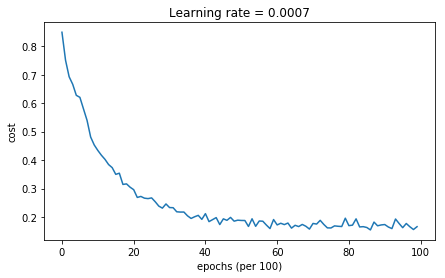

Accuracy: 0.943333333333


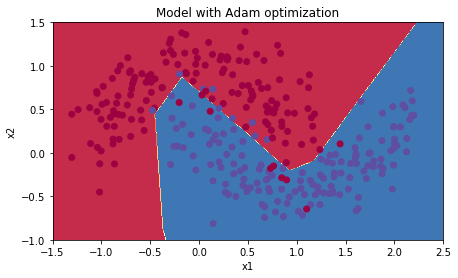

In [27]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

predictions = predict(train_X, train_Y, parameters)

plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)